<a href="https://colab.research.google.com/github/chrischo11/TimeSeriesAnalysis/blob/main/Airline_passenger_Covid_impact_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Case 1**

**Data Preparation**

In [1]:
# Load libraries
import re
import requests
import lxml
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from plotnine import *
import scipy as sc
from statsmodels.stats.weightstats import ztest
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


Q1.

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36'}
url = 'https://www.transtats.bts.gov/Data_Elements.aspx?Data=1'
r = requests.get('https://www.transtats.bts.gov/Data_Elements.aspx?Data=1', headers = headers,verify=False)
content = r.text
soup = BeautifulSoup(content, 'lxml') 

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings


In [3]:
columns = re.findall(r'<th scope="col">(.*?)</th>' ,str(soup), re.S|re.M)

In [4]:
columns

['Year', 'Month', 'DOMESTIC', 'INTERNATIONAL', 'TOTAL']

In [5]:
divs = soup.find_all(class_ = 'dataTDRight')
data_string = []
for div in divs:
    data_string.append(div.get_text(';'))
data_list = []
for d in data_string:
  data_list.append(d.split(';'))
data_list = data_list[2:]

In [6]:
data_string

['Foreign Carriers, 10,000 pax/mo to and from U.S.',
 'Destination',
 '\n;2002;10;48,054,917;9,578,435;57,633,352;\n',
 '\n;2002;11;44,850,246;9,016,535;53,866,781;\n',
 '\n;2002;12;49,684,353;10,038,794;59,723,147;\n',
 '\n;2002;TOTAL;551,899,643;118,704,850;670,604,493;\n',
 '\n;2003;1;43,032,450;9,726,436;52,758,886;\n',
 '\n;2003;2;41,166,780;8,283,372;49,450,152;\n',
 '\n;2003;3;49,992,700;9,538,653;59,531,353;\n',
 '\n;2003;4;47,033,260;8,309,305;55,342,565;\n',
 '\n;2003;5;49,152,352;8,801,873;57,954,225;\n',
 '\n;2003;6;52,209,516;10,347,900;62,557,416;\n',
 '\n;2003;7;55,810,773;11,705,206;67,515,979;\n',
 '\n;2003;8;53,920,973;11,799,672;65,720,645;\n',
 '\n;2003;9;44,213,408;9,454,647;53,668,055;\n',
 '\n;2003;10;49,944,935;9,608,358;59,553,293;\n',
 '\n;2003;11;47,059,495;9,481,886;56,541,381;\n',
 '\n;2003;12;49,757,124;10,512,547;60,269,671;\n',
 '\n;2003;TOTAL;583,293,766;117,569,855;700,863,621;\n',
 '\n;2004;1;43,815,481;10,252,443;54,067,924;\n',
 '\n;2004;2;45,306,64

In [7]:
for i in data_list:
  i.pop(0)
  i.pop()
for i,j in enumerate(data_list):
  if j[1] == 'TOTAL':
    del data_list[i]

In [8]:
df = pd.DataFrame(data_list,columns = columns)
for col in ['DOMESTIC','INTERNATIONAL','TOTAL']:
  df[col] = pd.to_numeric(df[col].str.replace(',', ''))

In [9]:
df.head()

,Year,Month,DOMESTIC,INTERNATIONAL,TOTAL
0,2002,10,48054917,9578435,57633352
1,2002,11,44850246,9016535,53866781
2,2002,12,49684353,10038794,59723147
3,2003,1,43032450,9726436,52758886
4,2003,2,41166780,8283372,49450152


Q2. Cleaning and preparing Domestic & International air passenger data

In [10]:
df1=df.loc[df['Month']!='TOTAL',['Year','Month','DOMESTIC']]
df1.dropna(inplace=True)
df1=df1.reset_index()
df1['index']=df1.index
df1.rename(columns={'DOMESTIC':'amount'},inplace=True)
df1.head()

,index,Year,Month,amount
0,0,2002,10,48054917
1,1,2002,11,44850246
2,2,2002,12,49684353
3,3,2003,1,43032450
4,4,2003,2,41166780


In [11]:
df2=df.loc[df['Month']!='TOTAL',['Year','Month','INTERNATIONAL']].reset_index().drop(columns='index')
df2.dropna(inplace=True)
df2=df2.reset_index()
df2['index']=df2.index
df2.rename(columns={'INTERNATIONAL':'amount'},inplace=True)
df2.head()

,index,Year,Month,amount
0,0,2002,10,9578435
1,1,2002,11,9016535
2,2,2002,12,10038794
3,3,2003,1,9726436
4,4,2003,2,8283372


In [12]:
df1.loc[209]

index          209
Year          2020
Month            3
amount    34420555
Name: 209, dtype: object

In [13]:
df1.loc[221]

index          221
Year          2021
Month            3
amount    39343495
Name: 221, dtype: object

In [14]:
df1['recession']=0
df1.loc[209:221,'recession']=1
df2['recession']=0
df2.loc[209:221,'recession']=1

**Data Understanding**

Q3.

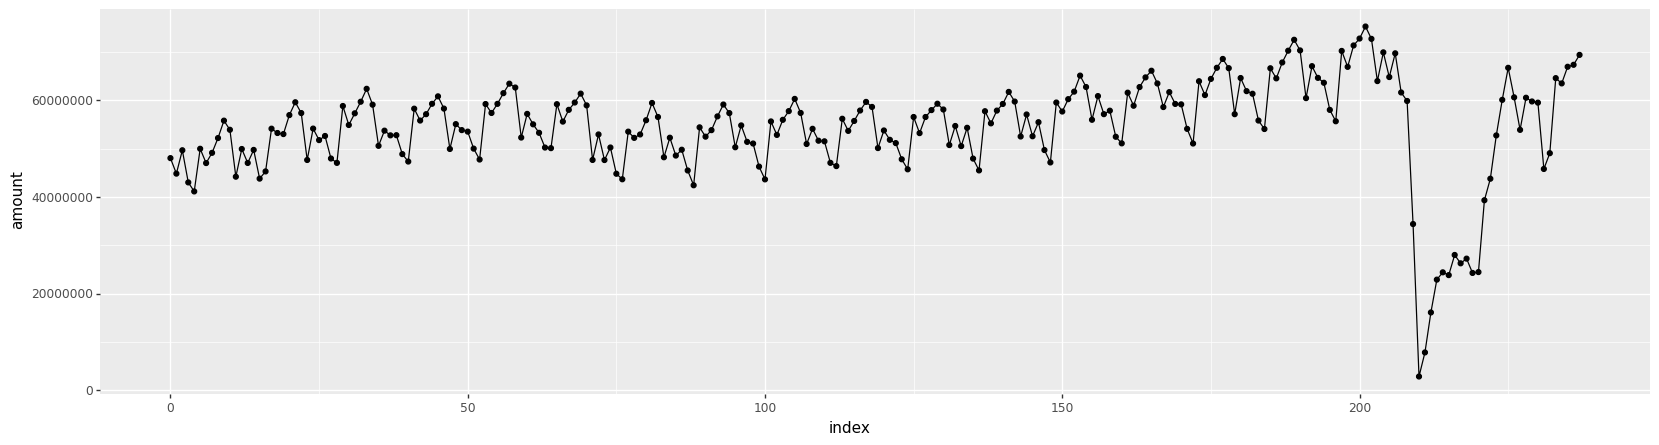

<ggplot: (8738773275133)>

In [15]:
(
   ggplot(df1,aes('index','amount')) + geom_point() + geom_line() + 
   theme(figure_size=(20,5))
) 

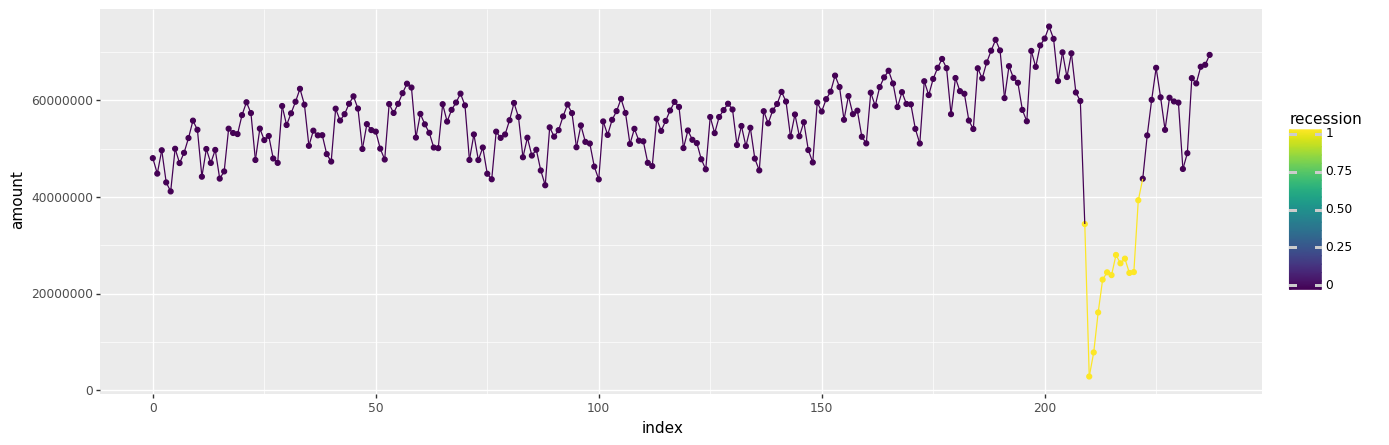

<ggplot: (8738773134393)>

In [16]:
# Domestic
(
   ggplot(df1,aes('index','amount')) + geom_point(aes(color="recession")) + geom_line(aes(color="recession")) + 
   theme(figure_size=(15,5))
)

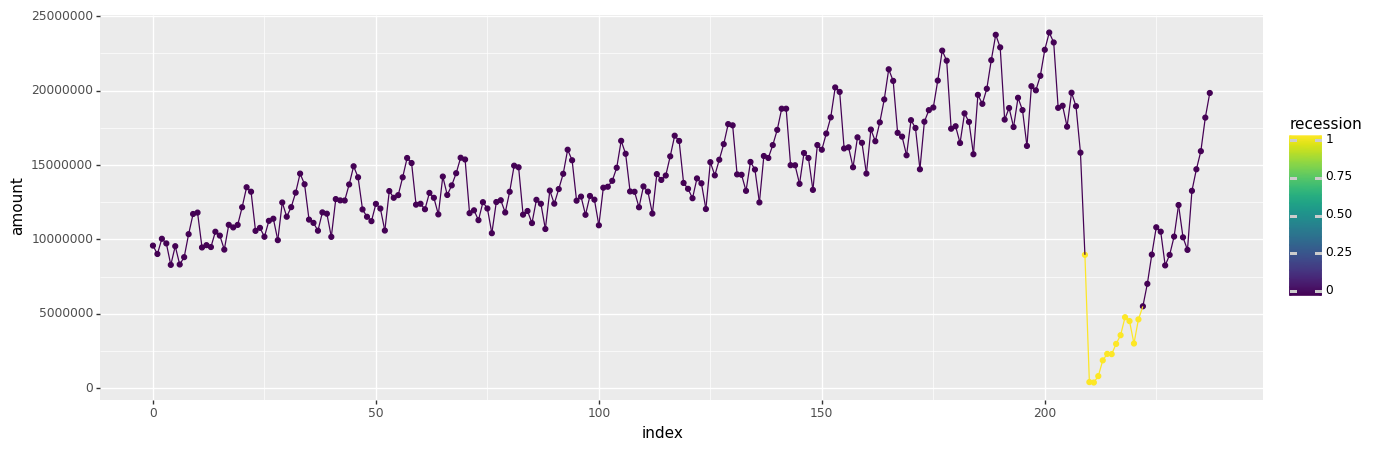

<ggplot: (8738773242329)>

In [17]:
# International
(
   ggplot(df2,aes('index','amount')) + geom_point(aes(color="recession")) + geom_line(aes(color="recession")) + 
   theme(figure_size=(15,5))
)

Q4.

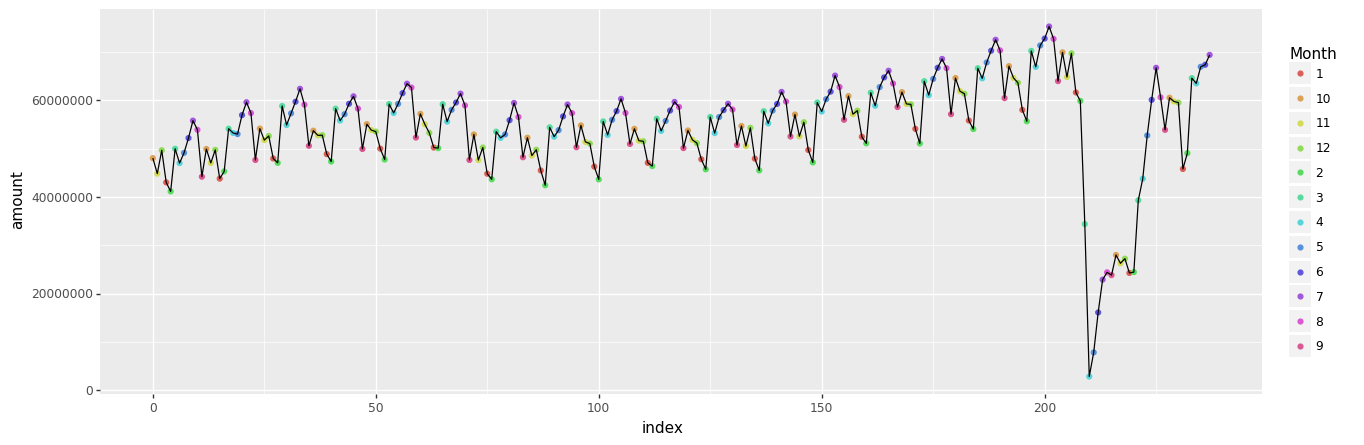

<ggplot: (8738771526601)>

In [18]:
# Domestic
(
   ggplot(df1,aes('index','amount')) + geom_point(aes(color="Month")) + geom_line() + 
   theme(figure_size=(15,5))
)

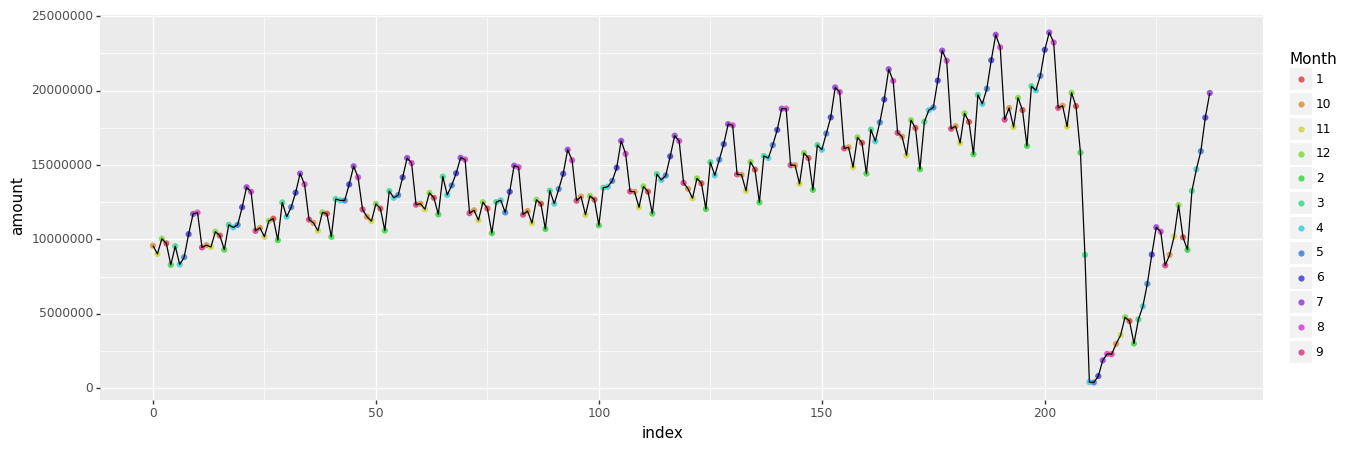

<ggplot: (8738768817445)>

In [19]:
# International
(
   ggplot(df2,aes('index','amount')) + geom_point(aes(color="Month")) + geom_line() + 
   theme(figure_size=(15,5))
)

**Modeling**

Q5.

**Domestic**

In [20]:
df1['trend'] = range(1, len(df1)+1)
df1['amountbefore']=df1.amount
df1.loc[(df1.trend>=210),'amountbefore'] = np.nan

# We'd better exclude the covid + post covid periods in this model.
# Based on the pre-post covid period pattern, we have to forecast the passenger demand of covid period.

In [21]:
df1.iloc[200:]

,index,Year,Month,amount,recession,trend,amountbefore
200,200,2019,6,72790418,0,201,72790418.0
201,201,2019,7,75281916,0,202,75281916.0
202,202,2019,8,72729199,0,203,72729199.0
203,203,2019,9,63991365,0,204,63991365.0
204,204,2019,10,69936836,0,205,69936836.0
205,205,2019,11,64827417,0,206,64827417.0
206,206,2019,12,69737438,0,207,69737438.0
207,207,2020,1,61638893,0,208,61638893.0
208,208,2020,2,59879630,0,209,59879630.0
209,209,2020,3,34420555,1,210,NaN


In [22]:
M1 = smf.ols('amountbefore ~ trend + C(Month)',data=df1).fit()
M1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           amountbefore   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     60.11
Date:                Sat, 15 Oct 2022   Prob (F-statistic):           5.49e-59
Time:                        06:01:08   Log-Likelihood:                -3421.1
No. Observations:                 209   AIC:                             6868.
Df Residuals:                     196   BIC:                             6912.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        4.26e+07   8.52e+05     50.018      0.000    4.09e+07    4.43e+07
C(Month)[T.10]  7.253e+06   1.07e+06      6.776      0.000    5.14e+06    9.36e+06
C(Month)[T.11]  4.145e+06   1.07e+06      3.872      0.000    2.03e+06    6.26e+06
C(Month)[T.12]  5.172e+06   1.07e+06      4.832      0.000    3.06e+06    7.28e+06
C(Month)[T.2]  -1.738e+06   1.07e+06     -1.624      0.106   -3.85e+06    3.73e+05
C(Month)[T.3]   9.111e+06   1.09e+06      8.388      0.000    6.97e+06    1.13e+07
C(Month)[T.4]   6.523e+06   1.09e+06      6.005      0.000    4.38e+06    8.66e+06
C(Month)[T.5]   8.845e+06   1.09e+06      8.144      0.000     6.7e+06     1.1e+07
C(Month)[T.6]   1.099e+07   1.09e+06     10.115      0.000    8.84e+06    1.31e+07
C(Month)[T.7]   1.325e+07   1.09e+06     12.203      0.000    1.11e+07    1.54e+07
C(Month)[T.8]   1.103e+07   1.09e+06     10.156      0.000    8.89e+06    1.32e+07
C(Month)[T.9]   2.574e+06   1.09e+06      2.370      0.019    4.32e+05    4.72e+06
trend           6.734e+04   3683.421     18.283      0.000    6.01e+04    7.46e+04
==============================================================================
Omnibus:                       83.898   Durbin-Watson:                   0.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.124
Skew:                           0.256   Prob(JB):                     0.000857
Kurtosis:                       1.834   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
df1['M1']=M1.fittedvalues
df1['M1residuals'] = M1.resid

In [24]:
df1.head()

,index,Year,Month,amount,recession,trend,amountbefore,M1,M1residuals
0,0,2002,10,48054917,0,1,48054917.0,4.992026e+07,-1.865340e+06
1,1,2002,11,44850246,0,2,44850246.0,4.687917e+07,-2.028927e+06
2,2,2002,12,49684353,0,3,49684353.0,4.797354e+07,1.710816e+06
3,3,2003,1,43032450,0,4,43032450.0,4.286889e+07,1.635556e+05
4,4,2003,2,41166780,0,5,41166780.0,4.119829e+07,-3.151492e+04


/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 29 rows containing missing values.


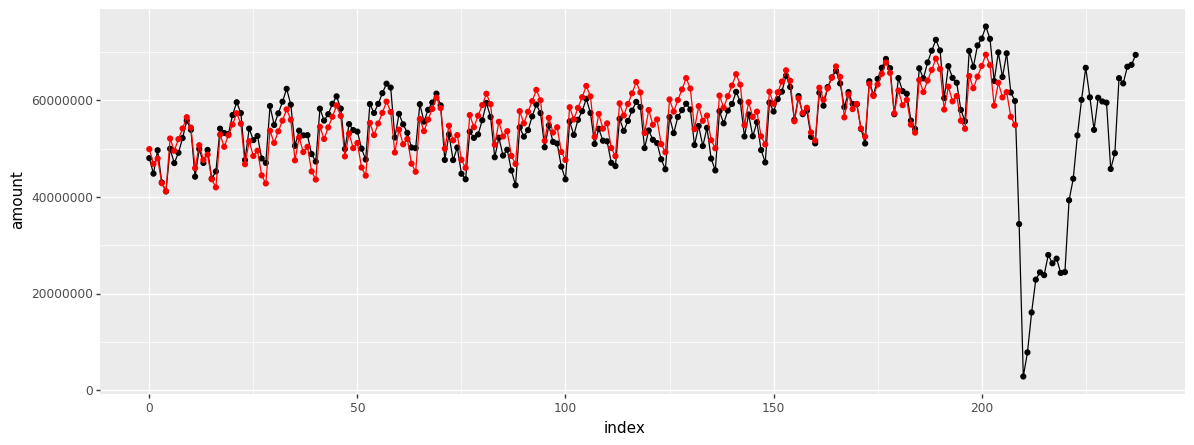

<ggplot: (8738771526609)>

In [25]:
(
   ggplot(df1,aes('index','amount')) + geom_point() + geom_line() + 
   geom_point(aes('index','M1'),color='red') + 
   geom_line(aes('index','M1'),color='red') + theme(figure_size=(14,5)) 
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 29 rows containing missing values.


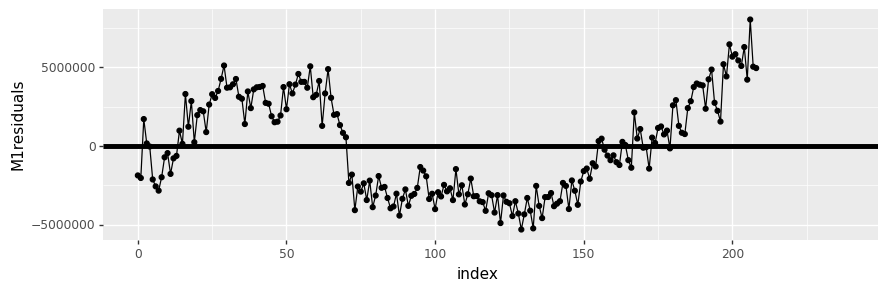

<ggplot: (8738768685545)>

In [26]:
(
   ggplot(df1,aes('index','M1residuals')) + geom_point() + geom_line()+ theme(figure_size=(10,3)) +
   geom_hline(yintercept = 0,size=2)
)

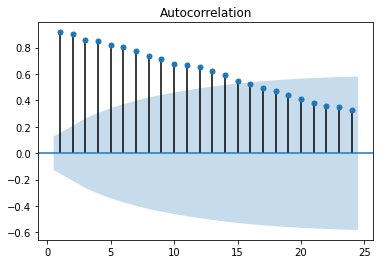

In [27]:
plot_acf(df1['M1residuals'], missing='drop',zero=False)
plt.show()

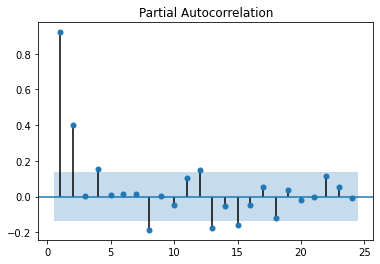

In [28]:
plot_pacf(df1.M1residuals[df1.M1residuals.notna()],zero=False)
plt.show()

In [29]:
# Create 4 lags of amountbefore in df1
df1['amountbeforeLag1'] = df1['amountbefore'].shift(1)  
df1['amountbeforeLag2'] = df1['amountbefore'].shift(2) 
df1['amountbeforeLag3'] = df1['amountbefore'].shift(3)
df1['amountbeforeLag4'] = df1['amountbefore'].shift(4) 
df1.head()

,index,Year,Month,amount,recession,trend,amountbefore,M1,M1residuals,amountbeforeLag1,amountbeforeLag2,amountbeforeLag3,amountbeforeLag4
0,0,2002,10,48054917,0,1,48054917.0,4.992026e+07,-1.865340e+06,NaN,NaN,NaN,NaN
1,1,2002,11,44850246,0,2,44850246.0,4.687917e+07,-2.028927e+06,48054917.0,NaN,NaN,NaN
2,2,2002,12,49684353,0,3,49684353.0,4.797354e+07,1.710816e+06,44850246.0,48054917.0,NaN,NaN
3,3,2003,1,43032450,0,4,43032450.0,4.286889e+07,1.635556e+05,49684353.0,44850246.0,48054917.0,NaN
4,4,2003,2,41166780,0,5,41166780.0,4.119829e+07,-3.151492e+04,43032450.0,49684353.0,44850246.0,48054917.0


In [30]:
# Build a regression model to model linear trend and additive seasonality + 4 lags
M2 = smf.ols('amountbefore ~ trend + C(Month) + amountbeforeLag1 + amountbeforeLag2 + amountbeforeLag3 + amountbeforeLag4',data=df1).fit()
M2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           amountbefore   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     461.3
Date:                Sat, 15 Oct 2022   Prob (F-statistic):          2.00e-141
Time:                        06:01:11   Log-Likelihood:                -3132.6
No. Observations:                 205   AIC:                             6299.
Df Residuals:                     188   BIC:                             6356.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.493e+06    1.3e+06     -2.690      0.008   -6.05e+06   -9.31e+05
C(Month)[T.10]    5.131e+06    7.8e+05      6.576      0.000    3.59e+06    6.67e+06
C(Month)[T.11]    2.129e+06   8.52e+05      2.498      0.013    4.48e+05    3.81e+06
C(Month)[T.12]     3.09e+06   9.52e+05      3.244      0.001    1.21e+06    4.97e+06
C(Month)[T.2]     -2.37e+05    7.1e+05     -0.334      0.739   -1.64e+06    1.16e+06
C(Month)[T.3]     1.401e+07   5.89e+05     23.783      0.000    1.28e+07    1.52e+07
C(Month)[T.4]     6.235e+06   1.07e+06      5.813      0.000    4.12e+06    8.35e+06
C(Month)[T.5]     6.805e+06   1.01e+06      6.769      0.000    4.82e+06    8.79e+06
C(Month)[T.6]     9.065e+06   6.24e+05     14.521      0.000    7.83e+06    1.03e+07
C(Month)[T.7]     7.746e+06   6.84e+05     11.317      0.000     6.4e+06     9.1e+06
C(Month)[T.8]     4.079e+06   5.84e+05      6.981      0.000    2.93e+06    5.23e+06
C(Month)[T.9]    -4.359e+06    5.3e+05     -8.227      0.000    -5.4e+06   -3.31e+06
trend             2751.5471   2116.351      1.300      0.195   -1423.299    6926.393
amountbeforeLag1     0.5017      0.072      6.934      0.000       0.359       0.644
amountbeforeLag2     0.3398      0.079      4.284      0.000       0.183       0.496
amountbeforeLag3    -0.0130      0.082     -0.158      0.875      -0.175       0.149
amountbeforeLag4     0.1517      0.073      2.082      0.039       0.008       0.295
==============================================================================
Omnibus:                        3.760   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                3.349
Skew:                           0.271   Prob(JB):                        0.187
Kurtosis:                       3.315   Cond. No.                     2.63e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

lag3's p-value is too high. so we will remove lag3.

In [31]:
# Build a regression model to model linear trend and additive seasonality + 3 lags
M2 = smf.ols('amountbefore ~ trend + C(Month) + amountbeforeLag1 + amountbeforeLag2 + amountbeforeLag4',data=df1).fit()
M2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           amountbefore   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     494.6
Date:                Sat, 15 Oct 2022   Prob (F-statistic):          8.96e-143
Time:                        06:01:11   Log-Likelihood:                -3132.6
No. Observations:                 205   AIC:                             6297.
Df Residuals:                     189   BIC:                             6350.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.556e+06   1.23e+06     -2.886      0.004   -5.99e+06   -1.13e+06
C(Month)[T.10]     5.11e+06   7.67e+05      6.664      0.000     3.6e+06    6.62e+06
C(Month)[T.11]    2.143e+06   8.45e+05      2.535      0.012    4.76e+05    3.81e+06
C(Month)[T.12]    3.203e+06   6.25e+05      5.128      0.000    1.97e+06    4.44e+06
C(Month)[T.2]    -1.887e+05    6.4e+05     -0.295      0.768   -1.45e+06    1.07e+06
C(Month)[T.3]     1.401e+07   5.87e+05     23.847      0.000    1.28e+07    1.52e+07
C(Month)[T.4]     6.343e+06   8.22e+05      7.714      0.000    4.72e+06    7.97e+06
C(Month)[T.5]     6.932e+06      6e+05     11.545      0.000    5.75e+06    8.12e+06
C(Month)[T.6]     9.041e+06   6.03e+05     14.988      0.000    7.85e+06    1.02e+07
C(Month)[T.7]     7.831e+06   4.25e+05     18.445      0.000    6.99e+06    8.67e+06
C(Month)[T.8]     4.136e+06   4.59e+05      9.001      0.000    3.23e+06    5.04e+06
C(Month)[T.9]     -4.32e+06   4.67e+05     -9.244      0.000   -5.24e+06    -3.4e+06
trend             2737.4741   2109.016      1.298      0.196   -1422.761    6897.709
amountbeforeLag1     0.4975      0.067      7.410      0.000       0.365       0.630
amountbeforeLag2     0.3367      0.077      4.388      0.000       0.185       0.488
amountbeforeLag4     0.1463      0.064      2.274      0.024       0.019       0.273
==============================================================================
Omnibus:                        3.700   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.290
Skew:                           0.267   Prob(JB):                        0.193
Kurtosis:                       3.316   Cond. No.                     1.75e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
df1['M2residuals'] = M2.resid
df1['M2']  = M2.fittedvalues

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 33 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 33 rows containing missing values.


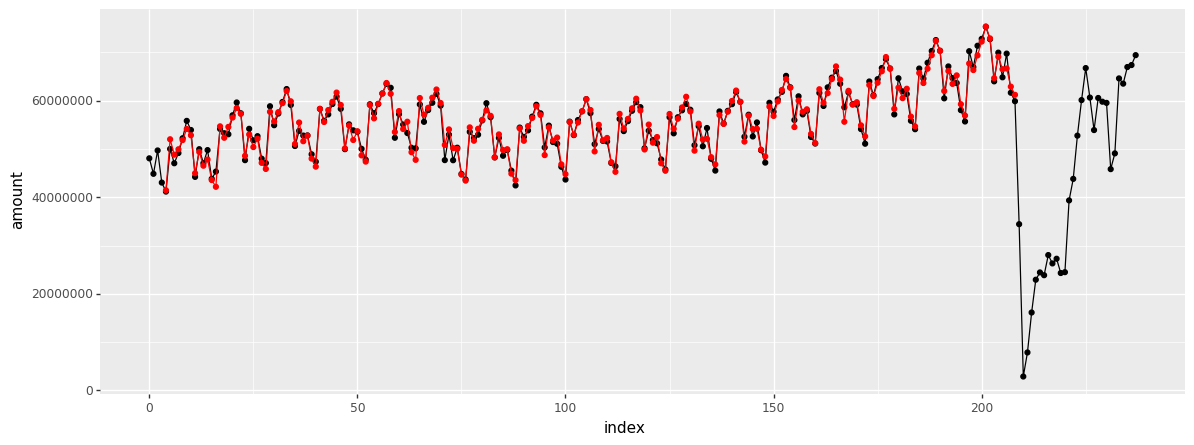

<ggplot: (8738773272405)>

In [33]:
(
   ggplot(df1,aes('index','amount')) + geom_point() + geom_line() + 
   geom_point(aes('index','M2'),color='red') + 
   geom_line(aes('index','M2'),color='red') + theme(figure_size=(14,5)) 
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 33 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 33 rows containing missing values.


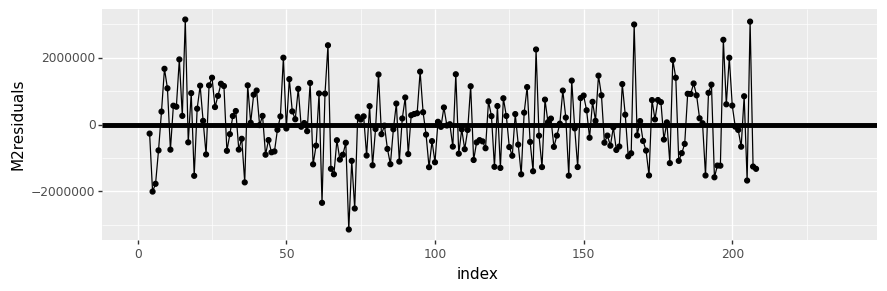

<ggplot: (8738768603661)>

In [34]:
(
   ggplot(df1,aes('index','M2residuals')) + geom_point() + geom_line()+ theme(figure_size=(10,3)) +
   geom_hline(yintercept = 0,size=2)
)

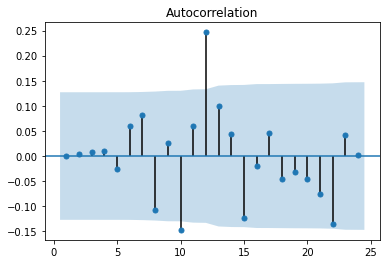

In [35]:
plot_acf(df1['M2residuals'], missing='drop',zero=False)
plt.show()

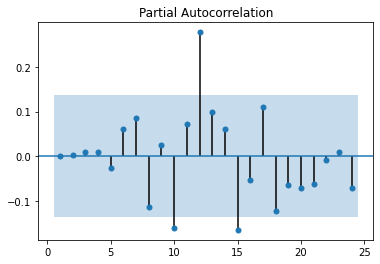

In [36]:
plot_pacf(df1.M2residuals[df1.M2residuals.notna()],zero=False)
plt.show()

In [37]:
# loop to predict sales before using M3 that contains lags on sales as explanatory variables
for i in list(range(209,237)) : # i represent row index
    df1.loc[i, 'amountbeforeLag1'] = df1.loc[i-1, 'amountbefore']
    df1.loc[i, 'amountbeforeLag2'] = df1.loc[i-2, 'amountbefore']
    df1.loc[i, 'amountbeforeLag3'] = df1.loc[i-3, 'amountbefore']
    df1.loc[i, 'amountbeforeLag4'] = df1.loc[i-4, 'amountbefore']
    df1.loc[i, 'M2'] = M2.predict(df1.iloc[[i]]).iloc[0]
    df1.loc[i, 'amountbefore'] = df1.loc[i, 'M2']

In [38]:
df1.iloc[209:237]

,index,Year,Month,amount,recession,trend,amountbefore,M1,M1residuals,amountbeforeLag1,amountbeforeLag2,amountbeforeLag3,amountbeforeLag4,M2residuals,M2
209,209,2020,3,34420555,1,210,7.105655e+07,NaN,NaN,5.987963e+07,6.163889e+07,6.973744e+07,6.482742e+07,NaN,7.105655e+07
210,210,2020,4,2879712,1,211,6.908007e+07,NaN,NaN,7.105655e+07,5.987963e+07,6.163889e+07,6.973744e+07,NaN,6.908007e+07
211,211,2020,5,7861491,1,212,7.126682e+07,NaN,NaN,6.908007e+07,7.105655e+07,5.987963e+07,6.163889e+07,NaN,7.126682e+07
212,212,2020,6,16132885,1,213,7.354308e+07,NaN,NaN,7.126682e+07,6.908007e+07,7.105655e+07,5.987963e+07,NaN,7.354308e+07
213,213,2020,7,22922158,1,214,7.584022e+07,NaN,NaN,7.354308e+07,7.126682e+07,6.908007e+07,7.105655e+07,NaN,7.584022e+07
214,214,2020,8,24431822,1,215,7.376771e+07,NaN,NaN,7.584022e+07,7.354308e+07,7.126682e+07,6.908007e+07,NaN,7.376771e+07
215,215,2020,9,23854772,1,216,6.537743e+07,NaN,NaN,7.376771e+07,7.584022e+07,7.354308e+07,7.126682e+07,NaN,6.537743e+07
216,216,2020,10,28027209,1,217,7.027142e+07,NaN,NaN,6.537743e+07,7.376771e+07,7.584022e+07,7.354308e+07,NaN,7.027142e+07
217,217,2020,11,26294514,1,218,6.725260e+07,NaN,NaN,7.027142e+07,6.537743e+07,7.376771e+07,7.584022e+07,NaN,6.725260e+07
218,218,2020,12,27264199,1,219,6.815814e+07,NaN,NaN,6.725260e+07,7.027142e+07,6.537743e+07,7.376771e+07,NaN,6.815814e+07


/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 5 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 5 rows containing missing values.


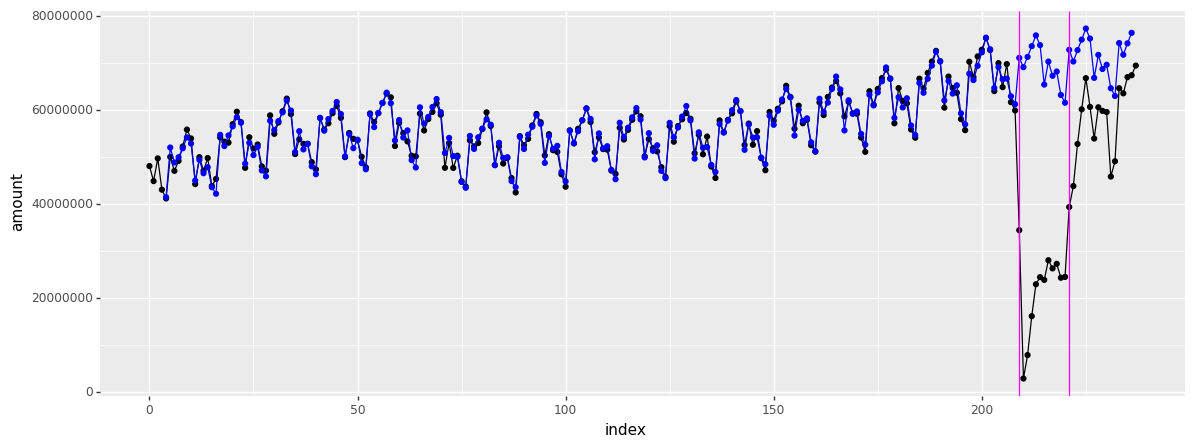

<ggplot: (8738768414981)>

In [39]:
# plot data and overlay M1 and M2
(
   ggplot(df1,aes('index','amount')) + geom_point() + geom_line() + 
   # geom_point(aes('index','M1'),color='red') + geom_line(aes('index','M1'),color='red') +
   geom_point(aes('index','M2'),color='blue') + geom_line(aes('index','M2'),color='blue') + 
   geom_vline(xintercept = 209, color='magenta', size=0.5) + geom_vline(xintercept = 221, color='magenta', size=0.5) +
   theme(figure_size=(14,5)) 
) 

Q6. Domestic

In [40]:
# 6. the total impact of COVID on DOMESTIC flight (Covid period)

df1['M2residuals'] = df1['amount'] - df1['M2']
df1.loc[(df1.index >= 209) & (df1.index <= 221), 'M2residuals'].sum()

-600841946.5542493

**International**

### Q5

In [41]:
df2['trend']=range(1,len(df2)+1)
df2['amountbefore']=df2.amount
df2.loc[(df2.trend>=210),'amountbefore'] = np.nan

In [42]:
df2.iloc[200:]

,index,Year,Month,amount,recession,trend,amountbefore
200,200,2019,6,22747453,0,201,22747453.0
201,201,2019,7,23907859,0,202,23907859.0
202,202,2019,8,23239180,0,203,23239180.0
203,203,2019,9,18842310,0,204,18842310.0
204,204,2019,10,18982654,0,205,18982654.0
205,205,2019,11,17575113,0,206,17575113.0
206,206,2019,12,19859635,0,207,19859635.0
207,207,2020,1,18955398,0,208,18955398.0
208,208,2020,2,15829198,0,209,15829198.0
209,209,2020,3,8956945,1,210,NaN


In [43]:
M1 = smf.ols('amountbefore ~ trend + C(Month)',data=df2).fit()
print(M1.summary())
df2['M1residuals'] = M1.resid
df2['M1']=M1.fittedvalues

                            OLS Regression Results                            
Dep. Variable:           amountbefore   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     230.6
Date:                Sat, 15 Oct 2022   Prob (F-statistic):          1.57e-108
Time:                        06:01:17   Log-Likelihood:                -3154.3
No. Observations:                 209   AIC:                             6335.
Df Residuals:                     196   BIC:                             6378.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       8.935e+06   2.38e+05     37.

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 29 rows containing missing values.


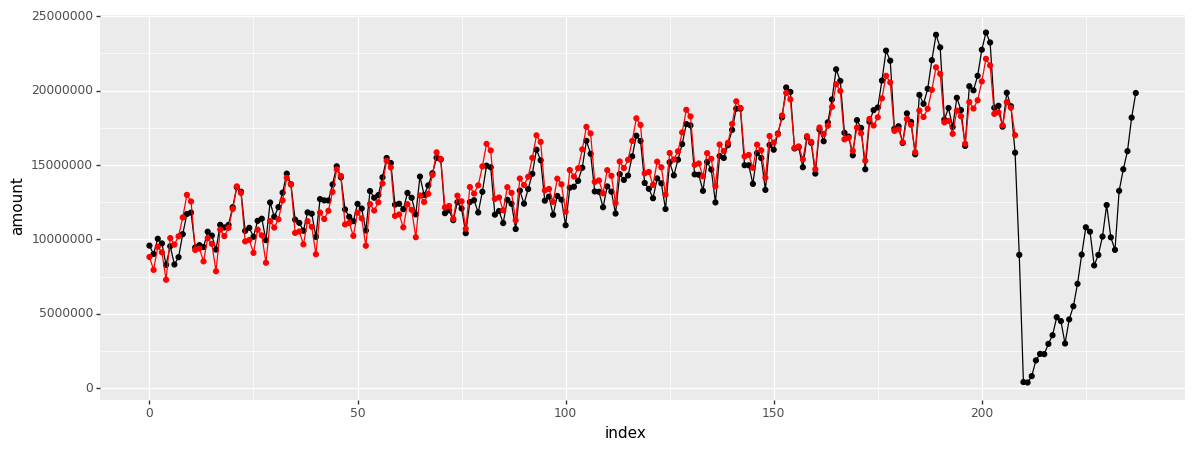

<ggplot: (8738768304117)>

In [44]:
(
   ggplot(df2,aes('index','amount')) + geom_point() + geom_line() + 
   geom_point(aes('index','M1'),color='red') + 
   geom_line(aes('index','M1'),color='red') + theme(figure_size=(14,5)) 
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 29 rows containing missing values.


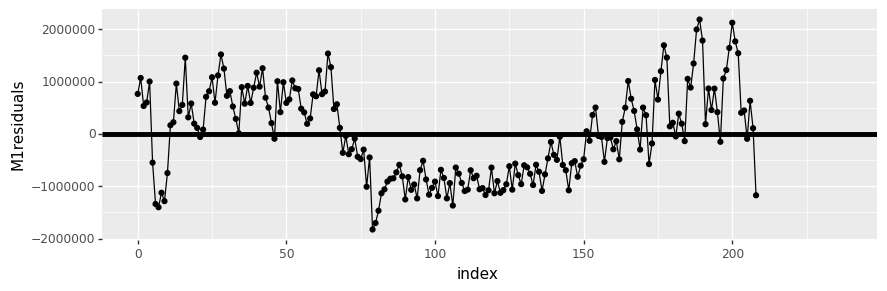

<ggplot: (8738768434277)>

In [45]:
(
   ggplot(df2,aes('index','M1residuals')) + geom_point() + geom_line()+ theme(figure_size=(10,3)) +
   geom_hline(yintercept = 0,size=2)
)

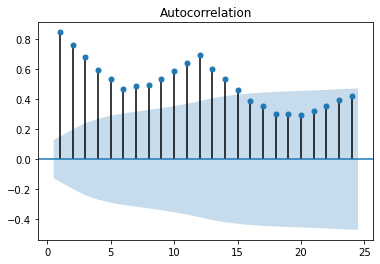

In [46]:
plot_acf(df2['M1residuals'], missing='drop',zero=False)
plt.show()

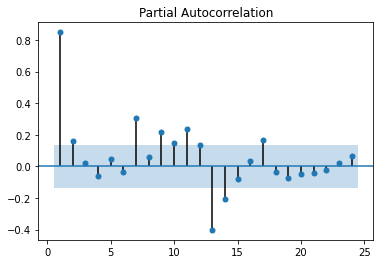

In [47]:
plot_pacf(df2.M1residuals[df2.M1residuals.notna()],zero=False)
plt.show()

In [48]:
# Create 2 lags of amountbefore in df2
df2['amountbeforeLag1'] = df2['amountbefore'].shift(1)  
df2['amountbeforeLag2'] = df2['amountbefore'].shift(2) 
df2['amountbeforeLag6'] = df2['amountbefore'].shift(6) 
df2['amountbeforeLag7'] = df2['amountbefore'].shift(7) 
df2.head()

,index,Year,Month,amount,recession,trend,amountbefore,M1residuals,M1,amountbeforeLag1,amountbeforeLag2,amountbeforeLag6,amountbeforeLag7
0,0,2002,10,9578435,0,1,9578435.0,7.643307e+05,8.814104e+06,NaN,NaN,NaN,NaN
1,1,2002,11,9016535,0,2,9016535.0,1.068809e+06,7.947726e+06,9578435.0,NaN,NaN,NaN
2,2,2002,12,10038794,0,3,10038794.0,5.333701e+05,9.505424e+06,9016535.0,9578435.0,NaN,NaN
3,3,2003,1,9726436,0,4,9726436.0,6.005108e+05,9.125925e+06,10038794.0,9016535.0,NaN,NaN
4,4,2003,2,8283372,0,5,8283372.0,1.001218e+06,7.282154e+06,9726436.0,10038794.0,NaN,NaN


In [49]:
# Build a regression model to model linear trend and additive seasonality + lags
M2 = smf.ols('amountbefore ~ trend + C(Month) + amountbeforeLag1 + amountbeforeLag2 +amountbeforeLag6+ amountbeforeLag7',data=df2).fit()
M2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           amountbefore   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     689.2
Date:                Sat, 15 Oct 2022   Prob (F-statistic):          1.81e-155
Time:                        06:01:19   Log-Likelihood:                -2902.5
No. Observations:                 202   AIC:                             5839.
Df Residuals:                     185   BIC:                             5895.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.066e+06   4.78e+05      2.232      0.027    1.24e+05    2.01e+06
C(Month)[T.10]   -8.863e+05   4.41e+05     -2.009      0.046   -1.76e+06   -1.58e+04
C(Month)[T.11]   -1.014e+06   2.31e+05     -4.396      0.000   -1.47e+06   -5.59e+05
C(Month)[T.12]    1.353e+06   2.39e+05      5.667      0.000    8.82e+05    1.82e+06
C(Month)[T.2]    -2.387e+06   2.43e+05     -9.838      0.000   -2.87e+06   -1.91e+06
C(Month)[T.3]     1.199e+06   4.29e+05      2.795      0.006    3.53e+05    2.05e+06
C(Month)[T.4]    -3.077e+04   2.43e+05     -0.127      0.899    -5.1e+05    4.49e+05
C(Month)[T.5]     8.955e+04   3.41e+05      0.263      0.793   -5.83e+05    7.62e+05
C(Month)[T.6]     1.633e+06   2.51e+05      6.494      0.000    1.14e+06    2.13e+06
C(Month)[T.7]     1.646e+06   2.84e+05      5.793      0.000    1.09e+06    2.21e+06
C(Month)[T.8]    -4.333e+05   4.13e+05     -1.048      0.296   -1.25e+06    3.82e+05
C(Month)[T.9]    -2.476e+06   3.71e+05     -6.667      0.000   -3.21e+06   -1.74e+06
trend             4084.4964   2060.752      1.982      0.049      18.900    8150.093
amountbeforeLag1     0.7144      0.070     10.134      0.000       0.575       0.853
amountbeforeLag2     0.1660      0.074      2.249      0.026       0.020       0.312
amountbeforeLag6    -0.2451      0.073     -3.339      0.001      -0.390      -0.100
amountbeforeLag7     0.2749      0.070      3.900      0.000       0.136       0.414
==============================================================================
Omnibus:                        3.846   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                4.684
Skew:                          -0.045   Prob(JB):                       0.0961
Kurtosis:                       3.740   Cond. No.                     9.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
df2['M2residuals'] = M2.resid
df2['M2']  = M2.fittedvalues

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 36 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 36 rows containing missing values.


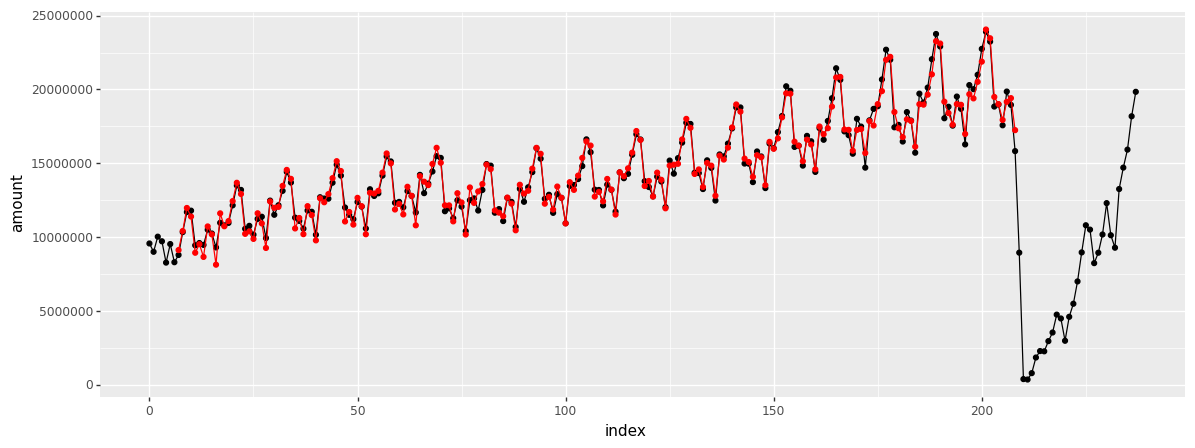

<ggplot: (8738768162485)>

In [51]:
(
   ggplot(df2,aes('index','amount')) + geom_point() + geom_line() + 
   geom_point(aes('index','M2'),color='red') + 
   geom_line(aes('index','M2'),color='red') + theme(figure_size=(14,5)) 
)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 36 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 36 rows containing missing values.


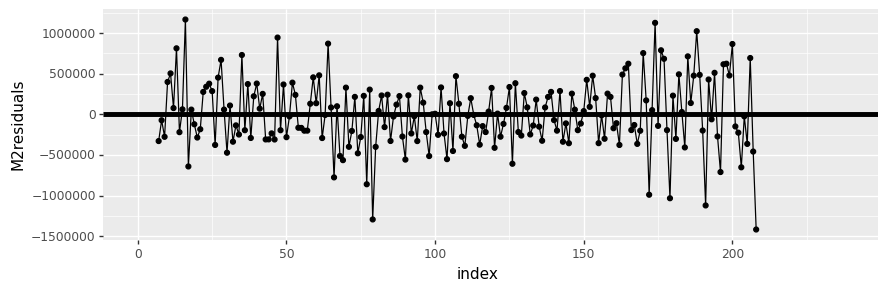

<ggplot: (8738768138457)>

In [52]:
(
   ggplot(df2,aes('index','M2residuals')) + geom_point() + geom_line()+ theme(figure_size=(10,3)) +
   geom_hline(yintercept = 0,size=2)
)

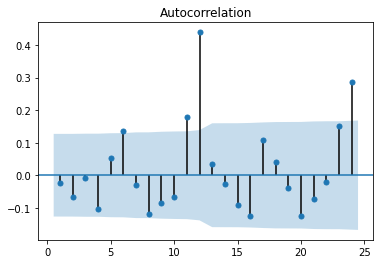

In [53]:
plot_acf(df2['M2residuals'], missing='drop',zero=False)
plt.show()

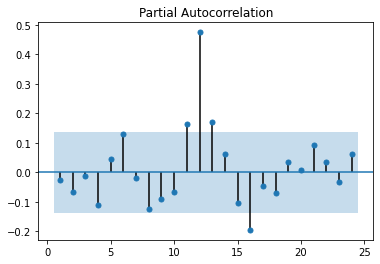

In [54]:
plot_pacf(df2.M2residuals[df2.M2residuals.notna()],zero=False)
plt.show()

In [55]:
# loop to predict sales before using M2 that contains lags on amount as explanatory variables
for i in list(range(209,237)) : # i represent row index
    df2.loc[i, 'amountbeforeLag1'] = df2.loc[i-1, 'amountbefore']
    df2.loc[i, 'amountbeforeLag2'] = df2.loc[i-2, 'amountbefore']
    df2.loc[i, 'amountbeforeLag6'] = df2.loc[i-6, 'amountbefore']
    df2.loc[i, 'amountbeforeLag7'] = df2.loc[i-7, 'amountbefore']
    df2.loc[i, 'M2'] = M2.predict(df2.iloc[[i]]).iloc[0]
    df2.loc[i, 'amountbefore'] = df2.loc[i, 'M2']

In [56]:
df2.loc[209:]

,index,Year,Month,amount,recession,trend,amountbefore,M1residuals,M1,amountbeforeLag1,amountbeforeLag2,amountbeforeLag6,amountbeforeLag7,M2residuals,M2
209,209,2020,3,8956945,1,210,1.934709e+07,NaN,NaN,1.582920e+07,1.895540e+07,1.884231e+07,2.323918e+07,NaN,1.934709e+07
210,210,2020,4,401329,1,211,1.887250e+07,NaN,NaN,1.934709e+07,1.582920e+07,1.898265e+07,1.884231e+07,NaN,1.887250e+07
211,211,2020,5,372915,1,212,1.962542e+07,NaN,NaN,1.887250e+07,1.934709e+07,1.757511e+07,1.898265e+07,NaN,1.962542e+07
212,212,2020,6,803948,1,213,2.068475e+07,NaN,NaN,1.962542e+07,1.887250e+07,1.985964e+07,1.757511e+07,NaN,2.068475e+07
213,213,2020,7,1862122,1,214,2.243331e+07,NaN,NaN,2.068475e+07,1.962542e+07,1.895540e+07,1.985964e+07,NaN,2.243331e+07
214,214,2020,8,2298093,1,215,2.230104e+07,NaN,NaN,2.243331e+07,2.068475e+07,1.582920e+07,1.895540e+07,NaN,2.230104e+07
215,215,2020,9,2280598,1,216,1.873676e+07,NaN,NaN,2.230104e+07,2.243331e+07,1.934709e+07,1.582920e+07,NaN,1.873676e+07
216,216,2020,10,2969651,1,217,1.884555e+07,NaN,NaN,1.873676e+07,2.230104e+07,1.887250e+07,1.934709e+07,NaN,1.884555e+07
217,217,2020,11,3553139,1,218,1.789283e+07,NaN,NaN,1.884555e+07,1.873676e+07,1.962542e+07,1.887250e+07,NaN,1.789283e+07
218,218,2020,12,4763815,1,219,1.954876e+07,NaN,NaN,1.789283e+07,1.884555e+07,2.068475e+07,1.962542e+07,NaN,1.954876e+07


In [ ]:
# plot data and overlay M1 and M2
(
   ggplot(df2,aes('index','amount')) + geom_point() + geom_line() + 
   geom_point(aes('index','M2'),color='blue') + geom_line(aes('index','M2'),color='blue') + 
   geom_vline(xintercept = 209, color='magenta', size=1) + geom_vline(xintercept = 221, color='magenta', size=1) +
   theme(figure_size=(14,5)) 
) 

Q6. International

In [ ]:
# 6. the total impact of COVID on International flight (Covid period)

df2['M2residuals'] = df2['amount'] - df2['M2']
df2.loc[(df2.index >= 209) & (df2.index <= 221), 'M2residuals'].sum()

Q7. estimated impact on a percentage scale

In [ ]:
# domestic  
# ((actual domestic passenger during covid) - (forcasted domestic passenger during covid)) / (forcasted domestic passenger during covid)
actual_domestic_covid = df1.loc[df1['recession']==1,'amount'].sum()
forecast_domestic_covid = df1.loc[df1['recession']==1,'M2'].sum()
(actual_domestic_covid - forecast_domestic_covid) / forecast_domestic_covid

# 66.5% decreased 

In [ ]:
# international
actual_international_covid = df2.loc[df2['recession']==1,'amount'].sum()
forecast_international_covid = df2.loc[df2['recession']==1,'M2'].sum()
(actual_international_covid - forecast_international_covid) / forecast_international_covid

# 84.1% decreased

Q8.	Has the industry recovered? If yes, when?

compare the "precovid period's M2 residual average" and each postcovid periods' M2 residual values <br>
IF specific post period's residual <= precovid period's M2 residual mean, recovered

In [ ]:
# Domestic
df1_domestic = df1.loc[222:,['Year','Month', 'M2', 'amount']]
df1_domestic['postcovid_diff'] = df1_domestic['M2'] - df1_domestic['amount']
df1_domestic['precovid_diff_mean'] = df1.loc[:208,'M2residuals'].mean() * -1
df1_domestic

Residual values in every post covid period is bigger than precovid period's residual average. Thus, we can say that the industry is not recovered yet.

In [ ]:
#international
precovid_residual = df2.loc[:208,'M2residuals'].mean()
postcovid_residual = df2.loc[222:,'M2residuals'].mean()
print(precovid_residual,postcovid_residual)

Q9. assess whether your model that you built overfits the data? (cross-validation for time series). <br> Briefly explain your approach. RMSE and MAPE may be helpful. 

In [ ]:
def rmse(y_actual,y_predicted):
    return ((((y_actual- y_predicted)**2).mean())**0.5).round(2)

In [ ]:
def mape(y_actual,y_predicted):
    return ((abs(y_actual - y_predicted)/y_actual).mean()*100).round(2)

In [ ]:
def accuracy(y_actual,y_predicted,h=0):
    n_train = len(y_actual) - h
    accuracy_metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','RMSE'] = rmse(y_actual[:n_train],y_predicted[:n_train])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(y_actual[:n_train],y_predicted[:n_train])
    if (h>0):
        accuracy_metrics.loc['Testing set','RMSE'] = rmse(y_actual[n_train:],y_predicted[n_train:])
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(y_actual[n_train:],y_predicted[n_train:])
    return accuracy_metrics

**Scenario 1 Domestic** <br>
Training set: start = 10/2002, end=12/2019 <br>
Testing set:   start = 01/2020, end=12/2020


In [ ]:
df1=df.loc[df['Month']!='TOTAL',['Year','Month','DOMESTIC']]
df1.dropna(inplace=True)
df1=df1.reset_index()
df1['index']=df1.index
df1.rename(columns={'DOMESTIC':'amount'},inplace=True)
df1['trend']=range(1,len(df1)+1)

df1['amountLag1'] = df1['amount'].shift(1)  
df1['amountLag2'] = df1['amount'].shift(2) 
df1['amountLag3'] = df1['amount'].shift(3)
df1['amountLag4'] = df1['amount'].shift(4) 
df1.head()

In [ ]:
s1_d=df1.loc[:218,['Year','Month','amount','trend','amountLag1', 'amountLag2', 'amountLag3', 'amountLag4']]
s1_d.tail(13)

In [ ]:
# training M2 model with 2002-10 to 2019-12 data
M2 = smf.ols('amount ~ trend + C(Month) + amountLag1 + amountLag2 + amountLag4',data=s1_d.iloc[:207]).fit()
s1_d['M2']=M2.predict(s1_d)

In [ ]:
s1_d.tail(13)

In [ ]:
accuracy(s1_d['amount'],s1_d['M2'], h=12)

**Scenario 1 International**

In [ ]:
df2=df.loc[df['Month']!='TOTAL',['Year','Month','INTERNATIONAL']]
df2.dropna(inplace=True)
df2=df2.reset_index()
df2['index']=df2.index
df2.rename(columns={'INTERNATIONAL':'amount'},inplace=True)
df2['trend']=range(1,len(df2)+1)

df2['amountLag1'] = df2['amount'].shift(1)  
df2['amountLag2'] = df2['amount'].shift(2) 
df2['amountLag6'] = df2['amount'].shift(6) 
df2['amountLag7'] = df2['amount'].shift(7) 
df2.head()

In [ ]:
s1_i=df2.loc[:218,['Year','Month','amount','trend','amountLag1', 'amountLag2', 'amountLag6', 'amountLag7']]
s1_i.tail(13)

In [ ]:
# training M2 model with 2002-10 to 2019-12 data
M2 = smf.ols('amount ~ trend + C(Month) + amountLag1 + amountLag2 + amountLag6 + amountLag7',data=s1_i.iloc[:207]).fit()
s1_i['M2']=M2.predict(s1_i)

In [ ]:
accuracy(s1_i['amount'],s1_i['M2'],h=12)

Testing set includes covid period. <br>
That's why this model cannot explain Testing period.

**Scenario 2 Domestic**<br>
Training set: start = 10/2002, end=12/2018 <br>
Testing set:   start = 01/2019, end=12/2019


In [ ]:
s2_d=df1.loc[:206,['Year','Month','amount','trend','amountLag1', 'amountLag2', 'amountLag3', 'amountLag4']]
s2_d.tail(13)

In [ ]:
M2 = smf.ols('amount ~ trend + C(Month) + amountLag1 + amountLag2 + amountLag4',data=s2_d.iloc[:195]).fit()
s2_d['M2']=M2.predict(s2_d)

In [ ]:
accuracy(s2_d['amount'],s2_d['M2'],h=12)

**Scenario 2 International**

In [ ]:
s2_i=df2.loc[:206,['Year','Month','amount','trend','amountLag1', 'amountLag2', 'amountLag6', 'amountLag7']]
s2_i.tail()

In [ ]:
M2 = smf.ols('amount ~ trend + C(Month) + amountLag1 + amountLag2 + amountLag6 + amountLag7',data=s2_i.iloc[:195]).fit()
s2_i['M2']=M2.predict(s2_i)

In [ ]:
accuracy(s2_i['amount'],s2_i['M2'],h=12)

**Scenario 3 Domestic** <br>
Training set: start = 10/2002, end=12/2017 <br>
Testing set:   start = 01/2018, end=12/2018


In [ ]:
s3_d=df1.loc[:194,['Year','Month','amount','trend','amountLag1', 'amountLag2', 'amountLag3', 'amountLag4']]
s3_d.tail(13)

In [ ]:
M2 = smf.ols('amount ~ trend + C(Month) + amountLag1 + amountLag2 + amountLag4',data=s3_d.iloc[:183]).fit()
s3_d['M2']=M2.predict(s3_d)

In [ ]:
accuracy(s3_d['amount'],s3_d['M2'],h=12)

**Scenario 3 International**

In [ ]:
s3_i=df2.loc[:194,['Year','Month','amount','trend','amountLag1', 'amountLag2', 'amountLag6', 'amountLag7']]
s3_i.tail()

In [ ]:
M2 = smf.ols('amount ~ trend + C(Month) + amountLag1 + amountLag2 + amountLag6 + amountLag7',data=s3_i.iloc[:183]).fit()
s3_i['M2']=M2.predict(s3_i)

In [ ]:
accuracy(s3_i['amount'],s3_i['M2'],h=12)

Q10.  M2 is okay enough. so let's make a new M2 model with every dataset information

In [ ]:
#domestic
M2 = smf.ols('amount ~ trend + C(Month) + amountLag1 + amountLag2 + amountLag4',data=df1).fit()
df1['M2'] = M2.fittedvalues
for i in range(len(df1),len(df1)+12):
    df1.loc[i,'index']=df1.loc[i-1,'index']+1
    df1.loc[i,'trend']=df1.loc[i-1,'trend']+1
    if int(df1.loc[i-1,'Month'])==12:
        df1.loc[i,'Month']=str(1)
    else:
        df1.loc[i,'Month']=str(int(df1.loc[i-1,'Month'])+1)
    df1.loc[i,'amountLag1']=df1.loc[i-1,'M2']
    df1.loc[i,'amountLag2']=df1.loc[i-2,'M2']
    df1.loc[i,'amountLag4']=df1.loc[i-4,'M2']
    df1.loc[i,'M2']=M2.predict(df1.iloc[[i]]).iloc[0]
predictions=M2.get_prediction(df1)
summary1 = predictions.summary_frame(alpha=0.05)
for i in range(4,len(df1)):
  df1.loc[i,'mean_ci_lower']=summary1.loc[i-4,'mean_ci_lower']
  df1.loc[i,'mean_ci_upper']=summary1.loc[i-4,'mean_ci_upper']
  df1.loc[i,'obs_ci_lower']=summary1.loc[i-4,'obs_ci_lower']
  df1.loc[i,'obs_ci_upper']=summary1.loc[i-4,'obs_ci_upper']

In [ ]:
df1.tail(13)

In [ ]:
#international
M2 = smf.ols('amount ~ trend + C(Month) + amountLag1 + amountLag2 + amountLag6 + amountLag7',data=df2).fit()
df2['M2'] = M2.fittedvalues
for i in range(len(df2),len(df2)+12):
    df2.loc[i,'index']=df2.loc[i-1,'index']+1
    df2.loc[i,'trend']=df2.loc[i-1,'trend']+1
    if int(df2.loc[i-1,'Month'])==12:
        df2.loc[i,'Month']=str(1)
    else:
        df2.loc[i,'Month']=str(int(df2.loc[i-1,'Month'])+1)
    df2.loc[i,'amountLag1']=df2.loc[i-1,'M2']
    df2.loc[i,'amountLag2']=df2.loc[i-2,'M2']
    df2.loc[i,'amountLag6']=df2.loc[i-6,'M2']
    df2.loc[i,'amountLag7']=df2.loc[i-7,'M2']
    df2.loc[i,'M2']=M2.predict(df2.iloc[[i]]).iloc[0]
predictions=M2.get_prediction(df2)
summary2=predictions.summary_frame(alpha=0.05)
for i in range(7,len(df2)):
  df2.loc[i,'mean_ci_lower']=summary2.loc[i-7,'mean_ci_lower']
  df2.loc[i,'mean_ci_upper']=summary2.loc[i-7,'mean_ci_upper']
  df2.loc[i,'obs_ci_lower']=summary2.loc[i-7,'obs_ci_lower']
  df2.loc[i,'obs_ci_upper']=summary2.loc[i-7,'obs_ci_upper']

In [ ]:
df2.tail(13)

### Q11

In [ ]:
#domestic
plt.rcParams["figure.figsize"] = (14,5.5)
plt.plot('index','amount',data=df1,color='black')
plt.plot('index','M2',data=df1,color='red')
plt.fill_between(df1['index'], df1['mean_ci_lower'], df1['mean_ci_upper'], color='yellow', alpha=0.5)
plt.fill_between(df1['index'], df1['obs_ci_lower'], df1['obs_ci_upper'], color='blue', alpha=0.1)
plt.show()

In [ ]:
#international
plt.rcParams["figure.figsize"] = (14,5.5)
plt.plot('index','amount',data=df2,color='black')
plt.plot('index','M2',data=df2,color='red')
plt.fill_between(df2['index'], df2['mean_ci_lower'], df2['mean_ci_upper'], color='yellow', alpha=0.5)
plt.fill_between(df2['index'], df2['obs_ci_lower'], df2['obs_ci_upper'], color='blue', alpha=0.1)
plt.show()

## CASE2

In [ ]:
nike=pd.read_excel('Nike.xlsx',header=10)
nike=nike.iloc[10,1:114]
nike=pd.DataFrame(nike)
nike=nike.rename(columns={10:'GP'})
nike['GP']=nike['GP'].astype('int')
nike['quarter']=nike.index.str[-1]
nike = nike.reset_index()
nike

In [ ]:
adidas=pd.read_excel('Adidas.xlsx',header=10)
adidas=adidas.iloc[10,21:111]
adidas=pd.DataFrame(adidas)
adidas=adidas.rename(columns={10:'GP'})
adidas['GP']=adidas['GP'].astype('int')
adidas['quarter']=adidas.index.str[-1]
adidas = adidas.reset_index()
adidas

In [ ]:
nike.loc[104:108]

In [ ]:
adidas.loc[84:88]

In [ ]:
nike['covid']=0
adidas['covid']=0

nike.loc[104:108,'covid']=1
adidas.loc[84:88,'covid']=1

nike['trend']=range(len(nike)+1)[1:]
adidas['trend']=range(len(adidas)+1)[1:]

nike['GPbefore'] = nike['GP']
nike.loc[nike.index >= 104, 'GPbefore'] = np.nan

adidas['GPbefore'] = adidas['GP']
adidas.loc[adidas.index >= 84, 'GPbefore'] = np.nan

## Nike case

In [ ]:
M1 = smf.ols('GPbefore ~ trend + C(quarter)',data=nike).fit()
print(M1.summary())

In [ ]:
nike['M1'] = M1.fittedvalues
nike['M1residuals'] = M1.resid

In [ ]:
plot_acf(nike['M1residuals'], missing='drop',zero=False)
plt.show()

In [ ]:
plot_pacf(nike.M1residuals[nike.M1residuals.notna()],zero=False)
plt.show()

In [ ]:
# Create 5 lags of GPbefore in nike
nike['GPbeforeLag1'] = nike['GPbefore'].shift(1)
nike['GPbeforeLag3'] = nike['GPbefore'].shift(3)  
nike['GPbeforeLag4'] = nike['GPbefore'].shift(4) 
nike['GPbeforeLag5'] = nike['GPbefore'].shift(5) 
nike['GPbeforeLag6'] = nike['GPbefore'].shift(6) 

In [ ]:
# Build a regression model to model linear trend and additive seasonality + 3 lags
M2 = smf.ols('GPbefore ~ trend + C(quarter) + GPbeforeLag1 + GPbeforeLag3 + GPbeforeLag4 + GPbeforeLag5 + GPbeforeLag6',data=nike).fit()
M2.summary()

In [ ]:
nike['M2residuals'] = M2.resid
nike['M2']  = M2.fittedvalues

In [ ]:
plot_acf(nike['M2residuals'], missing='drop',zero=False)
plt.show()

In [ ]:
plot_pacf(nike.M2residuals[nike.M2residuals.notna()],zero=False)
plt.show()

In [ ]:
nike.tail(10)

In [ ]:
# loop to predict sales before using M2 that contains lags on amount as explanatory variables
for i in list(range(104,113)) : # i represent row index
    nike.loc[i, 'GPbeforeLag1'] = nike.loc[i-1, 'GPbefore']
    nike.loc[i, 'GPbeforeLag3'] = nike.loc[i-3, 'GPbefore']
    nike.loc[i, 'GPbeforeLag4'] = nike.loc[i-4, 'GPbefore']
    nike.loc[i, 'GPbeforeLag5'] = nike.loc[i-5, 'GPbefore']
    nike.loc[i, 'GPbeforeLag6'] = nike.loc[i-6, 'GPbefore']
    nike.loc[i, 'M2'] = M2.predict(nike.iloc[[i]]).iloc[0]
    nike.loc[i, 'GPbefore'] = nike.loc[i, 'M2']

In [ ]:
(
   ggplot(nike,aes('trend','GP')) + geom_point() + geom_line() + 
   geom_point(aes('trend','M2'),color='red') + geom_line(aes('trend','M2'),color='red') + 
   geom_vline(xintercept = 105, color='magenta', size=0.5) + geom_vline(xintercept = 109, color='magenta', size=0.5) +
   theme(figure_size=(14,5)) 
) 

In [ ]:
nike.tail(10)

In [ ]:
# the total impact of COVID

nike['M2residuals'] = nike['GP'] - nike['M2']
nike.loc[((nike.index >= 105) & (nike.index <= 108)), 'M2residuals'].sum()

In [ ]:
# the total impact of after COVID

GP_diff_aftercovid = nike.loc[((nike.index > 108)), 'M2residuals'].sum() 

number_of_quarters_aftercovid = len(nike.loc[nike.index > 108])

GP_diff_aftercovid / number_of_quarters_aftercovid


After covid, nike suffered an abrupt $2,561,892 loss in gross profit. <br>
However, the gross profit increase by $360,832 per quarter after covid.

## Adidas case

In [ ]:
M1 = smf.ols('GPbefore ~ trend + C(quarter)',data=adidas).fit()
print(M1.summary())

In [ ]:
adidas['M1'] = M1.fittedvalues
adidas['M1residuals'] = M1.resid

In [ ]:
plot_pacf(adidas.M1residuals[adidas.M1residuals.notna()],zero=False)
plt.show()

In [ ]:
# Create lags of GPbefore in adidas
adidas['GPbeforeLag1'] = adidas['GPbefore'].shift(1) 
adidas['GPbeforeLag2'] = adidas['GPbefore'].shift(2) 
adidas['GPbeforeLag3'] = adidas['GPbefore'].shift(3) 
adidas['GPbeforeLag4'] = adidas['GPbefore'].shift(4) 
adidas['GPbeforeLag5'] = adidas['GPbefore'].shift(5) 

In [ ]:
# Build a regression model to model linear trend and additive seasonality + lags
M2 = smf.ols('GPbefore ~ trend + C(quarter) + GPbeforeLag1+ GPbeforeLag2+ GPbeforeLag3+GPbeforeLag4+ GPbeforeLag5',data=adidas).fit()
M2.summary()

In [ ]:
adidas['M2residuals'] = M2.resid
adidas['M2']  = M2.fittedvalues

In [ ]:
plot_pacf(adidas.M2residuals[adidas.M2residuals.notna()],zero=False)
plt.show()

In [ ]:
adidas.tail(10)

In [ ]:
for i in list(range(84,90)) : # i represent row index
    adidas.loc[i, 'GPbeforeLag1'] = adidas.loc[i-1, 'GPbefore']
    adidas.loc[i, 'GPbeforeLag2'] = adidas.loc[i-2, 'GPbefore']
    adidas.loc[i, 'GPbeforeLag3'] = adidas.loc[i-3, 'GPbefore']
    adidas.loc[i, 'GPbeforeLag4'] = adidas.loc[i-4, 'GPbefore']
    adidas.loc[i, 'GPbeforeLag5'] = adidas.loc[i-5, 'GPbefore']
    adidas.loc[i, 'M2'] = M2.predict(adidas.iloc[[i]]).iloc[0]
    adidas.loc[i, 'GPbefore'] = adidas.loc[i, 'M2']

In [ ]:
(
   ggplot(adidas,aes('trend','GP')) + geom_point() + geom_line() + 
   geom_point(aes('trend','M2'),color='red') + geom_line(aes('trend','M2'),color='red') + 
   geom_vline(xintercept = 85, color='magenta', size=0.5) + geom_vline(xintercept = 89, color='magenta', size=0.5) +
   theme(figure_size=(14,5)) 
) 

In [ ]:
# the total impact of COVID

adidas['M2residuals'] = adidas['GP'] - adidas['M2']
adidas.loc[((adidas.index >= 84) & (adidas.index <= 88)), 'M2residuals'].sum()

In [ ]:
# the total impact of after COVID

GP_diff_aftercovid = adidas.loc[((adidas.index > 88)), 'M2residuals'].sum() 

number_of_quarters_aftercovid = len(adidas.loc[adidas.index > 88])

GP_diff_aftercovid / number_of_quarters_aftercovid

After covid, adidas had an abrupt $3,084,160 decrease in gross profit. <br>
In addition, the gross profit decreased by $203,228 per quarter after covid.